# Veress Regression Grad-CAM

In [2]:
import numpy as np
import pandas as pd
from __future__ import print_function
import os, sys
import re
import time
import tensorflow as tf
from tensorflow import keras
from IPython.display 0import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg


# configure GPUs for tf
print("tf version", tf.version.VERSION)
my_gpu=0
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict tf one GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[my_gpu], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

tf version 2.5.0
2 Physical GPUs, 1 Logical GPU


In [3]:
path2data = "/home/jreynolds/21summer/veress/regression/data/"
images_dir = "distance_images/"
labels_dir = "distance_labels_20210803/"
path2images = path2data+images_dir
path2labels = path2data+labels_dir
labels_version = "20210803"

vid_list=[1,2,3,4,5,6,7,8]
dist_list=[0.4, 0.6, 0.8, 1.0, 1.2]

#all_excel_files = []
lookup_label = {}
for vid in vid_list:
    pathX=path2labels+"V"+str(vid)+"_distance_measurement_"+labels_version+".xlsx"
    book = pd.read_excel(pathX, engine='openpyxl', sheet_name=None, header=None, names=['pixels', 'distance'])
    temp_dict = {}
    for d in dist_list:
        sheet_name='V'+str(vid)+'_'+str(d)
        this_sheet = book[sheet_name]
        temp_dict[str(d)] = this_sheet
        #print("sheet: "+str(sheet_name))
        #print(this_sheet)
    lookup_label[str(vid)] = temp_dict
    #print("lookup_label["+str(vid)+"] = "+str(lookup_label[str(vid)]))
print(str(len(lookup_label))+" xlsx files")
print("\nNumber of subjects: "+str(len(lookup_label)))
print("Distances: "+ str(list(lookup_label['1'].keys())))
print("Number of labels per subject per distance category: "+str(len(lookup_label['1'][str(dist_list[0])])))
#print("teeeeempie: ", type(lookup_label['1'][str(dist_list[0])]))

8 xlsx files

Number of subjects: 8
Distances: ['0.4', '0.6', '0.8', '1.0', '1.2']
Number of labels per subject per distance category: 200


In [4]:
# get a list of full paths to the image data
dirs = os.listdir(path2images)
subdir_list=[]
count=0
for subdir in dirs:
    if re.match(r'V\d_\d.\d', subdir):
        subdir_list.append(path2images+str(subdir)+"/")
        count+=1
print("%d directories of images"%count)

40 directories of images


In [5]:
#r_image_number = re.compile(r'\d{1,3}(?=_V[0-9]+)')
#r_vid=re.compile(r'\d(?=<*_V)')
#r_vid = re.compile(r'\d(?=\d.\d.png\z)')

MasterDict={}
#master_vid_list=[]
#master_dist_list=[]
#master_raw_imgs_list=[]
#master_img_name=[]
#images_by_subject=[]
count =0
start=time.time()
for path in subdir_list:
    file_dir_temp = os.listdir(path)
    for img_name in file_dir_temp:
        # read the image with matplotlib mpimg
        path_img=path+"/"+img_name
        img = mpimg.imread(path_img, format = "png")
        #img=img[:,:,0]
        # use regex to extract info about the current file
        my_img_number = re.search(r'\d{1,3}(?=_V[0-9]+)', str(img_name))
        my_vid = re.search(r'(?<=V)\d', str(img_name))
        my_dist = re.search(r'\d.\d(?=.png)', str(img_name))
        img_details = (int(my_vid.group(0)), str(my_dist.group(0)), int(my_img_number.group(0)))
        # loop through labels for the eight subjects (excel files)
        found_flag=False
        tempList=[]
        for i in lookup_label:
            # find the matching subject ID
            if str(img_details[0]) == str(i) and found_flag==False:
                # for the given subject, loop through the five distance tables (excel files)
                for j in lookup_label[i]:
                    # find the matching excel sheet name
                    if str(img_details[1])==str(j) and found_flag==False:
                        # for the given subject (i) and distance (j), loop through the 200 distance labels (excel files) 
                        store_idx=[]
                        for idx, row in lookup_label[i][j].iterrows():
                            store_idx.append(idx)
                            # find the matching image index
                            if str(img_details[2]) == str(idx+1) and found_flag==False:
                                MasterDict[str(img_name)]=(img_details[0], img_details[1], img_details[2], float(row['distance']), img)
                                #master_dist_list.append(float(row['distance']))
                                #master_raw_imgs_list.append(img)
                                #tempList.append(img)
                                #master_vid_list.append(int(idx))
                                #master_img_name.append(img_name)
                                count += 1
                                found_flag = True
                                #if count % 1000 == 0:
                                #    print("completed images =", count)
        percentComplete=int((count/8000)*100)
        print(str(count)+" images processed; "+str(percentComplete)+"% percent complete", end='\r')
        sys.stdout.flush()
end = time.time()
print("Time taken to read "+str(len(MasterDict)), " images is ", str(end - start), "s")
#print(MasterDict)

Time taken to read 8000  images is  57.595003604888916 s


## Define the filename of the image to send through the Grad-CAM pipeline

In [6]:
# [0.4, 0.6, 0.8, 1.0, 1.2]
img_filename = "100_V4_0.6.png"

## display some info about the chosen image

100_V4_0.6.png
Subject:        4
Distance group: 0.6
image index:    100
true distance:  643.75


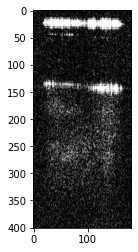

In [7]:
print(img_filename)
print("Subject:        %d"%MasterDict[img_filename][0])
print("Distance group: %s"%MasterDict[img_filename][1])
print("image index:    %d"%MasterDict[img_filename][2])
print("true distance:  %s"%MasterDict[img_filename][3])

my_img_path = "%sV%d_%smm/%d_V%d_%s.png"%(path2images, MasterDict[img_filename][0], MasterDict[img_filename][1], MasterDict[img_filename][2], MasterDict[img_filename][0], MasterDict[img_filename][1])
# show the image 
imgplot=plt.imshow(MasterDict[img_filename][4])

## confirm integrity of filename, image, and label mapping

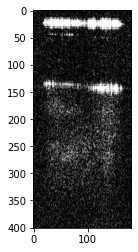

In [8]:
I = mpimg.imread(my_img_path, format="png")
imgplot=plt.imshow(I)

In [9]:
def GetSubjectNumberFromFilename(my_filename):
    # regex out the subject ID
    re_vid = re.search('(?<=V)\d', my_filename)
    return int(re_vid.group(0))

S=GetSubjectNumberFromFilename(img_filename)
arch_dict_winner = {1: "InceptionV3", 2: "InceptionV3", 3: "InceptionV3", 4: "Xception", 5: "InceptionV3", 6: "InceptionV3", 7: "InceptionV3", 8: "Xception"}
path2model="/home/jreynolds/21summer/veress/regression/data/export_model_results/v20210812/CT_results/ct_model_S%d_%s.h5"%(MasterDict[img_filename][0], arch_dict_winner[S])

## load model and make prediction on raw image

In [10]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
K.clear_session()
model_for_preds = keras.models.load_model(path2model)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
img_for_pred=I[:,:,0][np.newaxis, ..., np.newaxis]
raw_pred=model_for_preds.predict(img_for_pred)
print("prediction:   %.2f µm"%raw_pred[0][0])
print("ground truth: %.2f µm"%MasterDict[img_filename][3])

/home/jreynolds/anaconda3/envs/tf-gpu9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


prediction:   649.72 µm
ground truth: 643.75 µm


## Reload model and display model summary to find punultimate layer

In [12]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
K.clear_session()
model = keras.models.load_model(path2model)
model.summary()

Model: "model_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           [(None, 401, 181, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 90, 32)  288         input_88[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 200, 90, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 200, 90, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## regression activation heatmap 

100_V4_0.6.png


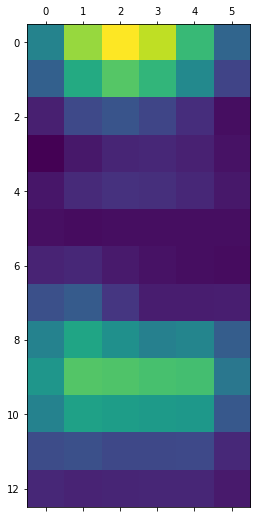

In [13]:
model_output = model.output[:, 0]
if arch_dict_winner[S] == "Xception":
    last_conv_layer = model.get_layer("block14_sepconv2_act") # Xception
elif arch_dict_winner[S] == "InceptionV3":
    last_conv_layer = model.get_layer("mixed10") # InceptionV3
grads=K.gradients(model_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

procd_image = I[:,:,0][np.newaxis, ..., np.newaxis]
pooled_grads_value, conv_layer_output_value = iterate([procd_image])

for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

print(img_filename)
plt.matshow(heatmap)

## single class heatmap activation overlay with original image

In [14]:
import cv2
# load the original img
img=cv2.imread(my_img_path)
# resize heatmap to the same size as the img
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)
# Apply heatmap to original img
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

re_vid = re.search('(?<=V)\d', img_filename)
# a gross way to extract filename without the file extension (.jpg)
re_fnoext=re.search(r"^[^jpg]*", img_filename)
fnoext=re_fnoext.group(0)
fnoext = fnoext.rstrip(fnoext[-1])
print(fnoext)
cv2.imwrite('export_regression_GradCAM/r_V%d_GradCAM_%s.jpg'%(int(re_vid.group(0)), fnoext), superimposed_img)

100_V4_0.6


True

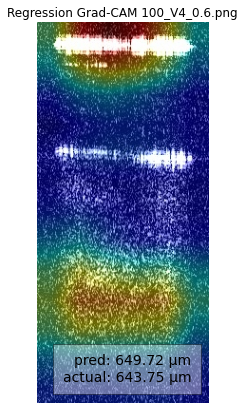

In [15]:
img = cv2.imread('export_regression_GradCAM/r_V%d_GradCAM_%s.jpg'%(int(re_vid.group(0)), fnoext))
#img2 = img[:,:,::-1]
img2 = img[:,:,::-1]
fig,ax=plt.subplots(figsize=(10,7))
ax.set_title("Regression Grad-CAM %s"%img_filename)
ax.set_axis_off()

#ax.text(0.95, 0.01, 'pred=%.2f µm, actual=%.2f µm'%(raw_pred[0][0], MasterDict[img_filename][3]), style='italic',
#        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes,
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax.text(0.90, 0.05, 'pred: %.2f µm\nactual: %.2f µm'%(raw_pred[0][0], MasterDict[img_filename][3]),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.40, 'pad': 10})


ax.imshow(img2)
fig.savefig('export_regression_GradCAM/r_GradCAM_actpred_%s.jpg'%(fnoext), bbox_inches="tight")
#plt.imshow(img)

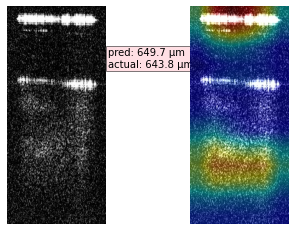

In [16]:
I = mpimg.imread(my_img_path, format="png")
#$imgplot=plt.imshow(I)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_axis_off()
ax1.imshow(I)
#ax2.set_title("Regression Grad-CAM %s"%img_filename)
ax2.set_axis_off()

ax1.text(
    #0.2, 0.30, 
    -1.02, 0.26, 
    'pred: %.1f µm\nactual: %.1f µm'%(raw_pred[0][0], MasterDict[img_filename][3]),
    verticalalignment='bottom', 
    horizontalalignment='left', 
    transform=ax.transAxes,
    color='black', fontsize=10.0, 
    bbox={'facecolor': 'pink', 'alpha': 0.50, 'pad': 1.6}
)
ax2.imshow(img2)